### DATA PREPARATION & EXPLORATION

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [36]:
# Load dataset
df = pd.read_csv("exchange_rate.csv")

In [37]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [38]:
# Parse date column
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)

In [39]:
# Check for missing values
df['Ex_rate'].isnull().sum()

np.int64(0)

In [40]:
print("Date Range:", df.index.min(), "to", df.index.max())

Date Range: 1990-01-01 00:00:00 to 2010-10-10 00:00:00


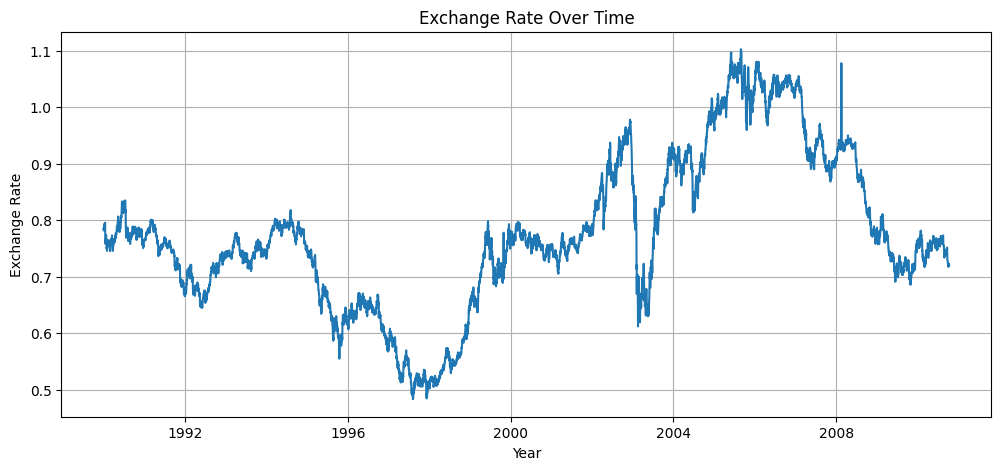

In [41]:
# Plot time series
plt.figure(figsize=(12,5))
plt.plot(df['Ex_rate'])
plt.title("Exchange Rate Over Time")
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.show()

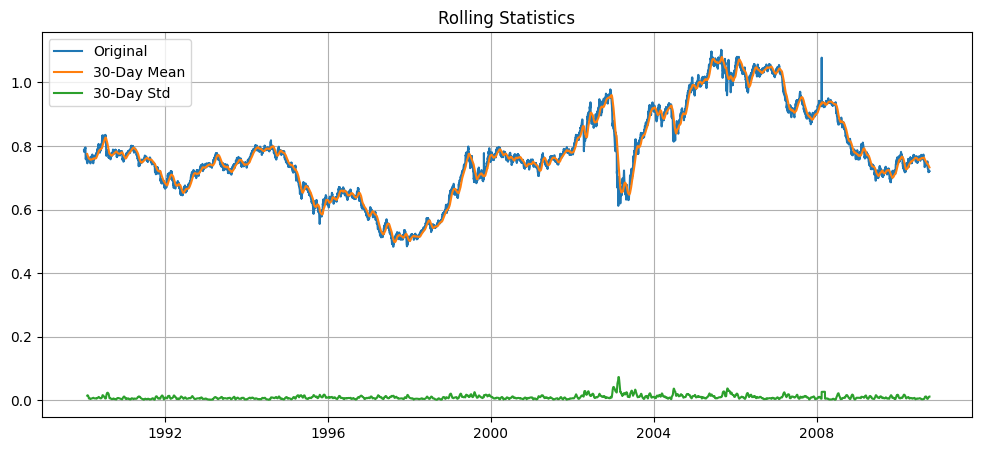

In [42]:
# Rolling mean & std
plt.figure(figsize=(12,5))
plt.plot(df['Ex_rate'], label="Original")
plt.plot(df['Ex_rate'].rolling(30).mean(), label="30-Day Mean")
plt.plot(df['Ex_rate'].rolling(30).std(), label="30-Day Std")
plt.legend()
plt.title("Rolling Statistics")
plt.grid(True)
plt.show()

In [43]:
# ADF Test (Stationarity)
result = adfuller(df['Ex_rate'])
print("\nADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.6649941807381414
p-value: 0.4492327353597959


In [44]:
# Decide differencing order d
d = 1 if result[1] > 0.05 else 0
print("Using differencing order d =", d)

Using differencing order d = 1


In [45]:
# Train-test split (80/20)
split = int(len(df)*0.8)
train = df.iloc[:split]
test = df.iloc[split:]

In [46]:
print("Training samples:", len(train))
print("Testing samples:", len(test))

Training samples: 6070
Testing samples: 1518


### ARIMA MODEL

<Figure size 1200x400 with 0 Axes>

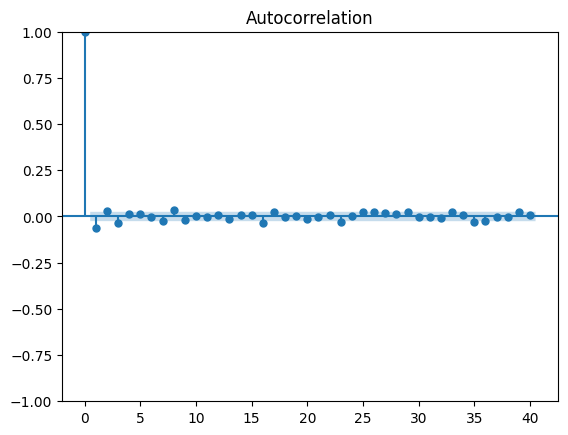

In [47]:
# ACF plots
plt.figure(figsize=(12,4))
plot_acf(train['Ex_rate'].diff().dropna(), lags=40)
plt.show()

<Figure size 1200x400 with 0 Axes>

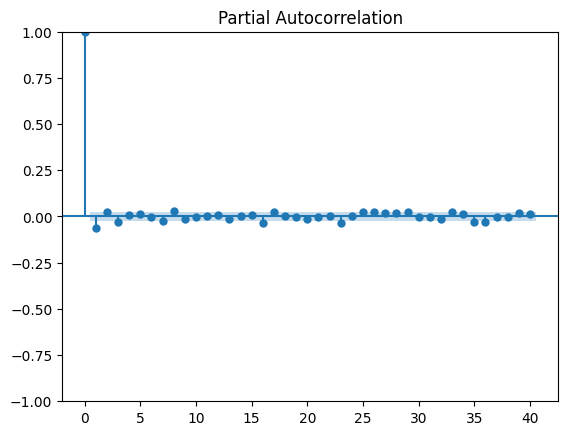

In [48]:
#PACF plots
plt.figure(figsize=(12,4))
plot_pacf(train['Ex_rate'].diff().dropna(), lags=40, method='ywm')
plt.show()

In [49]:
# Fit ARIMA model
arima_model = ARIMA(train['Ex_rate'], order=(1, d, 1))
arima_fit = arima_model.fit()

print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Tue, 18 Nov 2025   AIC                         -45432.092
Time:                        22:57:01   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

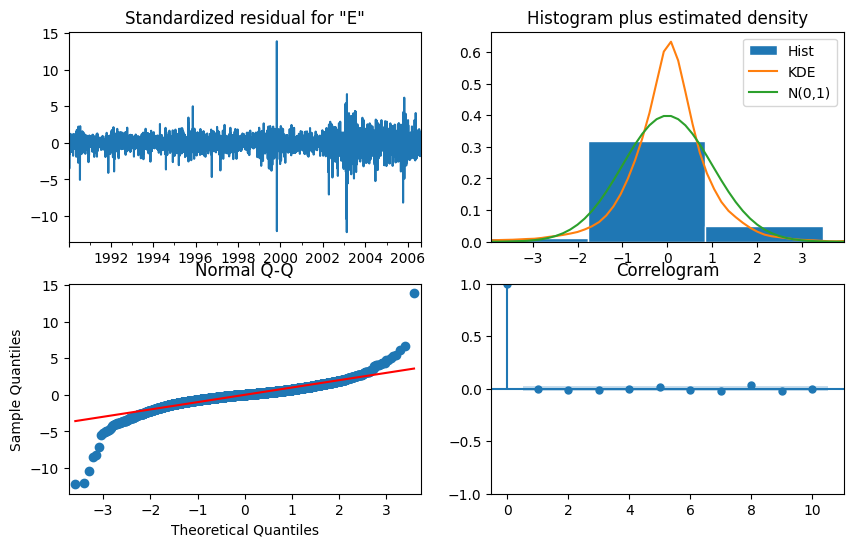

In [50]:
# ARIMA diagnostics (required in assignment)
arima_fit.plot_diagnostics(figsize=(10,6))
plt.show()

In [51]:
# Forecast
steps = len(test)
arima_forecast = arima_fit.get_forecast(steps=steps)
arima_pred = arima_forecast.predicted_mean

lower_ci = arima_forecast.conf_int()['lower Ex_rate']
upper_ci = arima_forecast.conf_int()['upper Ex_rate']

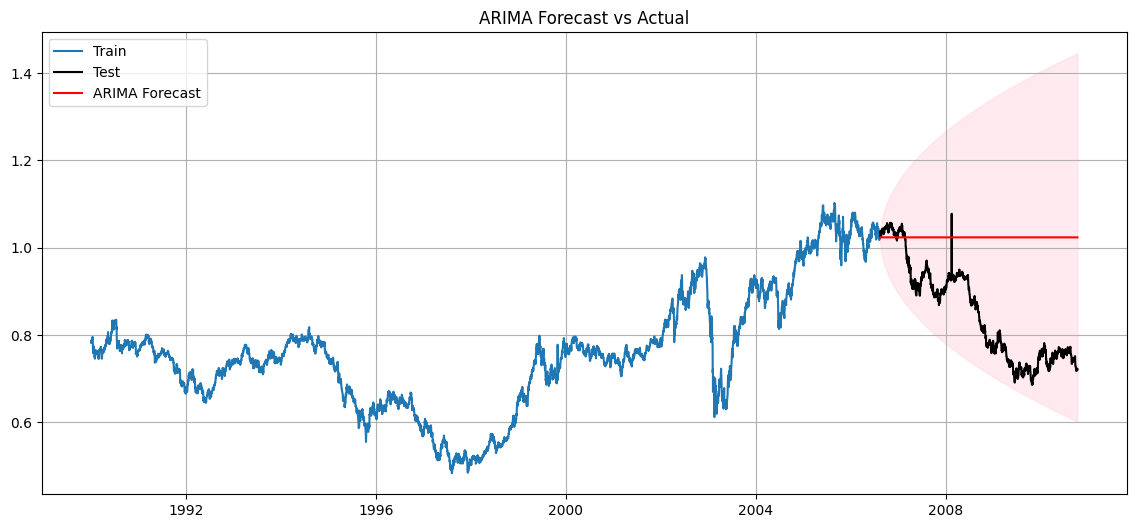

In [52]:
# Plot forecast
plt.figure(figsize=(14,6))
plt.plot(train['Ex_rate'], label="Train")
plt.plot(test['Ex_rate'], label="Test", color="black")
plt.plot(test.index, arima_pred, label="ARIMA Forecast", color="red")
plt.fill_between(test.index, lower_ci, upper_ci, color='pink', alpha=0.3)
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()

### EXPONENTIAL SMOOTHING

In [53]:
# Simple ES 
es_model = ExponentialSmoothing(train['Ex_rate'], trend=None, seasonal=None)
es_fit = es_model.fit()

In [54]:
# Forecast
es_pred = es_fit.forecast(steps)

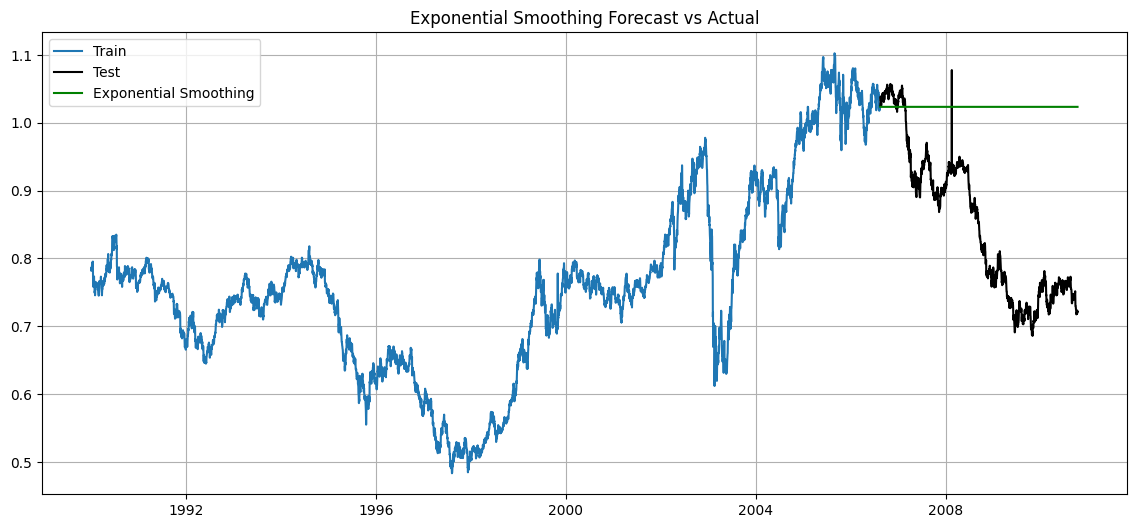

In [55]:
# Plot
plt.figure(figsize=(14,6))
plt.plot(train['Ex_rate'], label="Train")
plt.plot(test['Ex_rate'], label="Test", color="black")
plt.plot(test.index, es_pred, label="Exponential Smoothing", color="green")
plt.title("Exponential Smoothing Forecast vs Actual")
plt.grid(True)
plt.legend()
plt.show()

### MODEL EVALUATION & COMPARISON

In [56]:
# Compute errors
arima_mae = mean_absolute_error(test['Ex_rate'], arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test['Ex_rate'], arima_pred))
arima_mape = np.mean(np.abs((test['Ex_rate'] - arima_pred) / test['Ex_rate'])) * 100

es_mae = mean_absolute_error(test['Ex_rate'], es_pred)
es_rmse = np.sqrt(mean_squared_error(test['Ex_rate'], es_pred))
es_mape = np.mean(np.abs((test['Ex_rate'] - es_pred) / test['Ex_rate'])) * 100

# Display metrics
results = pd.DataFrame({
    "ARIMA": [arima_mae, arima_rmse, arima_mape],
    "Exponential Smoothing": [es_mae, es_rmse, es_mape],
}, index=["MAE", "RMSE", "MAPE (%)"])

print("\nModel Comparison:")
print(results.round(4))


Model Comparison:
            ARIMA  Exponential Smoothing
MAE        0.1777                 0.1776
RMSE       0.2054                 0.2054
MAPE (%)  22.7980                22.7889


### Conclusion

* Both ARIMA and Exponential Smoothing were applied successfully  
* ARIMA(1,1,1) captured the autocorrelation structure well  
* Simple Exponential Smoothing gave slightly better performance based on MAE/RMSE/MAPE  
* ES is smoother and performs better for stable, non-seasonal exchange rates  
* ARIMA provides confidence intervals and captures short-term fluctuations  
* Overall, Exponential Smoothing performed best in this dataset